# Pairs Trading with Machine Learning

In developing a Pairs Trading strategy, finding valid, eligible pairs which exhibit unconditional mean-reverting behavior is of critical importance. We use popular algorithms from Machine Learning to help us navigate a very high-dimensional seach space to find tradeable pairs.

In [59]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint
from scipy import stats
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

The pre-defined universe we’ll be working with is the Q1500 which is a large set of liquid stocks.

In [60]:
study_date = "2019-12-31"
universe = Q1500US()

# Data

To create our pipeline with we use information from Morningstar. We obtain the Market Cap, Type of Industry and Financial Health of the stock.

In [61]:
pipe = Pipeline(columns = {
'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
'Industry':morningstar.asset_classification.morningstar_industry_group_code.latest,
'Financial Health':morningstar.asset_classification.financial_health_grade.latest}, 
screen = universe)
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

In [62]:
print(res.shape)

(1486, 3)


In [63]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1486, 3)


We see that our data contains 1486 stocks and a description of financial health, industry, and market cap.

In [64]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print(res.shape)

(1484, 3)


In [65]:
# replace the categorical data with numerical scores per the docs by Morningstar 
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [66]:
res.describe()

,Financial Health,Industry,Market Cap
count,1484.000000,1484.000000,1484.000000
mean,0.447439,20811.819407,3.470350
std,0.269562,9118.431082,0.617619
min,0.100000,10110.000000,2.000000
25%,0.300000,10340.000000,3.000000
50%,0.300000,20630.000000,4.000000
75%,0.700000,31040.000000,4.000000
max,1.000000,31130.000000,4.000000


# Define Horizon

Get the daily returns (the dollar change in a stock’s price as a percentage of the previous day’s closing price) to use in our strategy. Then we look at the daily returns for Microsoft as an example.

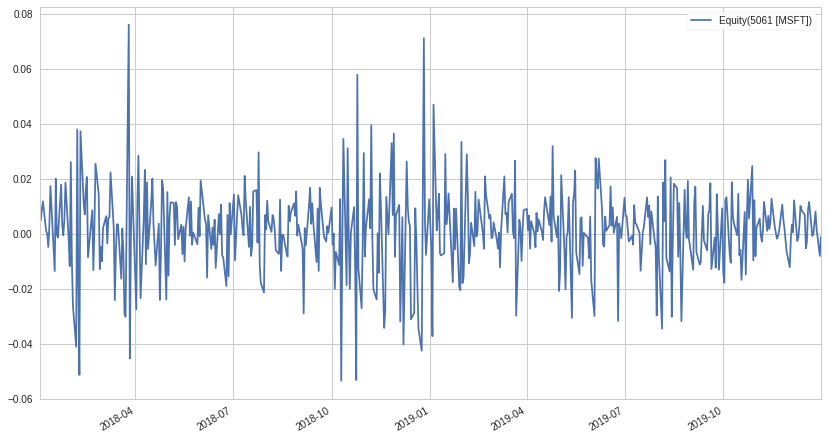

In [67]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)
returns = pricing.pct_change()
returns[symbols(['MSFT'])].plot()

In [68]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)
print(returns.shape)

(502, 1358)


# Find Candidate Pairs

Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

The first hypothesis above is that "Stocks that share loadings to common factors in the past should be related in the future". Common factors are things like sector/industry membership and widely known ranking schemes like momentum and value.

We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock. We will take these features, add in the fundamental features, and then use the DBSCAN unsupervised clustering algorithm 

# PCA Decomposition and DBSCAN Clustering

In [69]:
prin_components = 50 
pca = PCA(n_components=prin_components)
pca.fit(returns)

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


PCA(copy=True, n_components=50, whiten=False)

We have reduced data now with the first N_PRIN_COMPONENTS principal component loadings. Let's add some fundamental values as well to make the model more robust.

In [70]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

In [31]:
#scaling the data(standardization)
X = preprocessing.StandardScaler().fit_transform(X)

#implementing the DBSCAN algorithm
clf = DBSCAN(eps=1.9, min_samples=3)
print(clf)
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)
clustered = clf.labels_

/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/venvs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 15


In [33]:
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 921403 


The total number of possible pairs are over 900,000 so we’ll significantly reduce that number to only pairs that are among the better candidates for our pairs trading strategy.

In [34]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 15
Pairs to evaluate: 2256


We have reduced the number of pairs we need to evaluate from 921403 to 2256

# Cluster Visualization

We have found 11 clusters. The data are clustered in 52 dimensions. As an attempt to visualize what has happened in 2d, we can try with T-SNE. T-SNE is an algorithm for visualizing very high dimension data in 2d.

We visualize the discovered pairs to help us gain confidence that the DBSCAN output is sensible; i.e., we want to see that T-SNE and DBSCAN both find our clusters.

In [ ]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

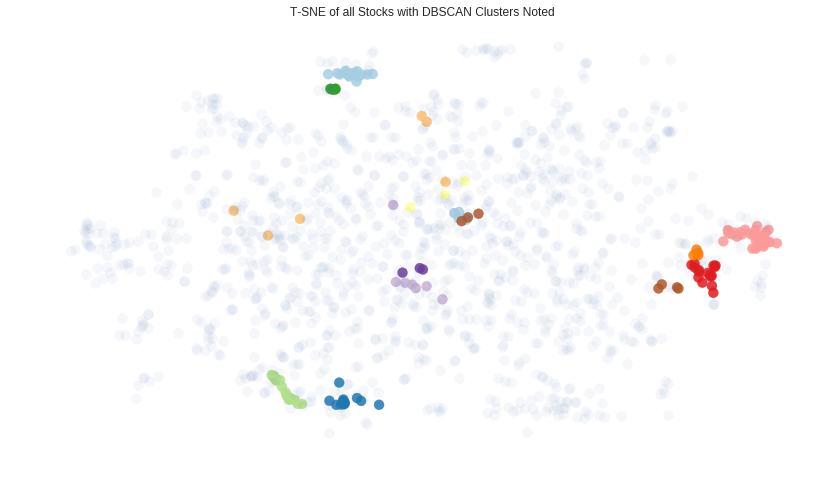

In [37]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

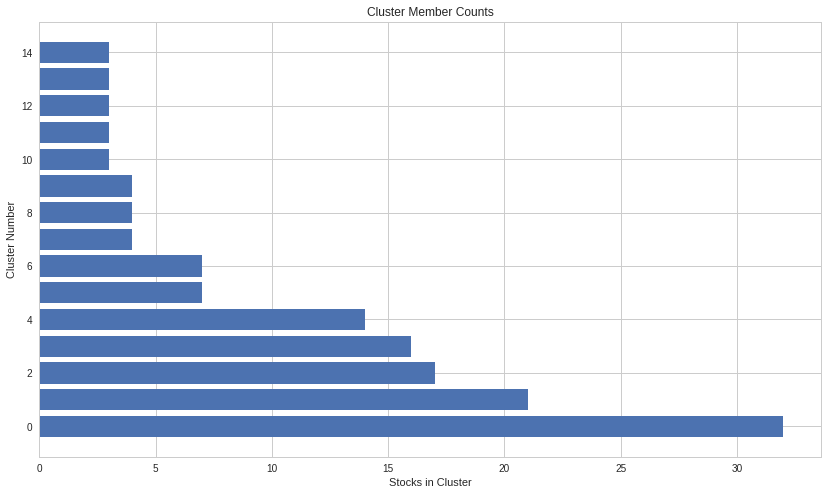

In [39]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

To again visualize if our clustering is doing anything sensible, let's look at a few clusters (for reproducibility, keep all random state and dates the same in this notebook).

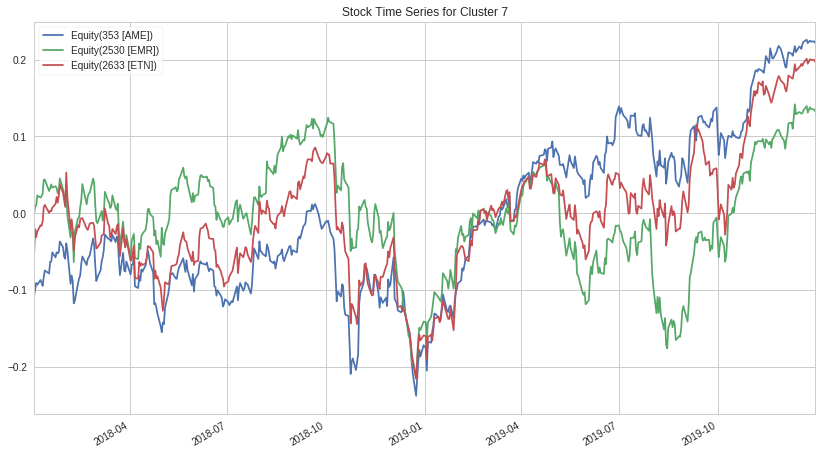

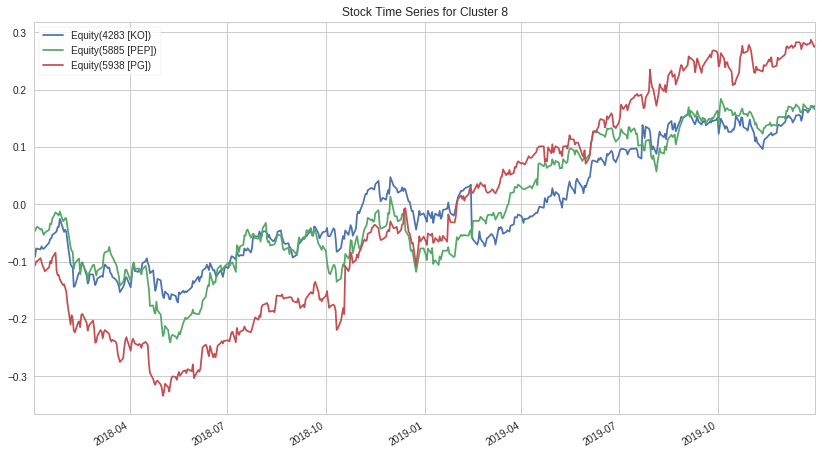

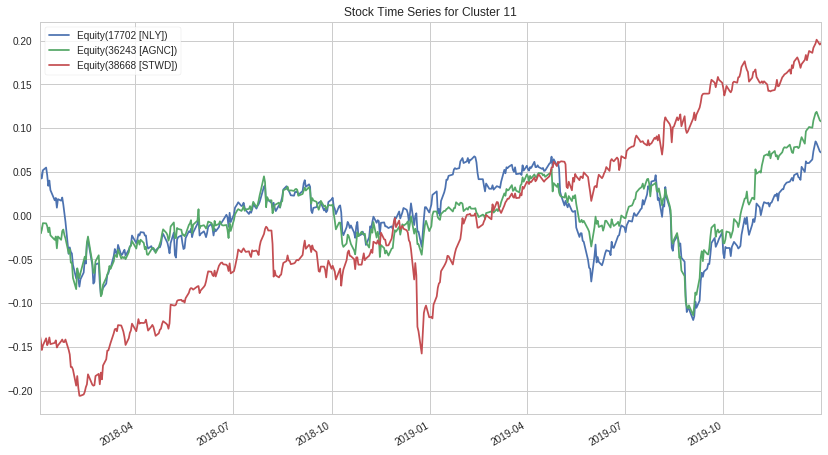

In [40]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

We might be interested to see how a cluster looks for a particular stock. Large bank stocks share similar strict regulatory oversight and are similarly economic and interest rate sensitive. We indeed see that our clustering has found a bank stock cluster.

In [41]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

Equity(700 [BAC])       3
Equity(1335 [C])        3
Equity(1620 [CMA])      3
Equity(2855 [FITB])     3
Equity(4221 [KEY])      3
Equity(5117 [MTB])      3
Equity(5479 [NTRS])     3
Equity(6068 [PNC])      3
Equity(8151 [WFC])      3
Equity(8399 [ZION])     3
Equity(17080 [MS])      3
Equity(19787 [EWBC])    3
Equity(20088 [GS])      3
Equity(25006 [JPM])     3
Equity(27421 [WAL])     3
Equity(34913 [RF])      3
Equity(47777 [CFG])     3
dtype: int64

Now that we have sensible clusters of common stocks, we can validate the cointegration relationships.

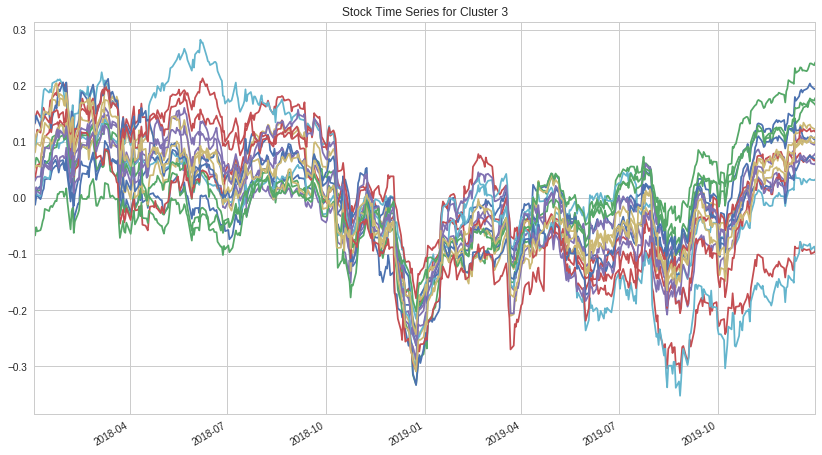

In [42]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

In [43]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [44]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [45]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [46]:
pairs

[(Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(161 [AEP]), Equity(36098 [AWK])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(2330 [DTE]), Equity(24783 [AEE])),
 (Equity(2351 [DUK]), Equity(5607 [OGE])),
 (Equity(2434 [ED]), Equity(2968 [NEE])),
 (Equity(2434 [ED]), Equity(5484 [ES])),
 (Equity(2434 [ED]), Equity(8140 [WEC])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2434 [ED]), Equity(36098 [AWK])),
 (Equity(2637 [ETR]), Equity(2968 [NEE])),
 (Equity(2637 [ETR]), Equity(7011 [SO])),
 (Equity(2968 [NEE]), Equity(6193 [WTRG])),
 (Equity(2968 [NEE]), Equity(7011 [SO])),
 (Equity(5310 [NI]), Equity(5607 [OGE])),
 (Equity(5310 [NI]), Equity(24783 [AEE])),
 (Equity(5607 [OGE]), Equity(24783 [AEE])),
 (Equity(8140 [WEC]), Equity(36098 [AWK])),
 (Equity(21964 [XEL]), Equity(36098 [AWK])),
 (Equity(266 [AJG]), Equity(438 [AON])),
 (Equity(2701 [FNB]), Equity(8011 [VLY])),
 (Equity(2701 [FNB]), Equity(23718 [PNFP])),
 (Equity(3066 [FULT]), Equity(8011 [VLY])),
 (Equity(306

In [47]:
print "We found %d pairs." % len(pairs)

We found 118 pairs.


In [48]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 88 unique tickers.


# Pair Visualization

We’ll use T-SNE again to visualize our validated pairs.

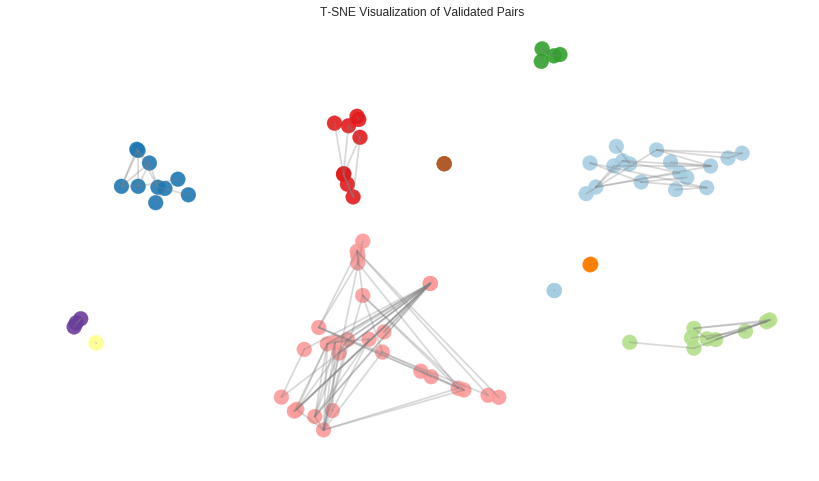

In [55]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=list(in_pairs_series.values), cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

# Conclusion

We have found pairs that we can use to construct our portofolio using the pair trading strategy we have created. 